In [1]:
import torch

from rl4co.envs import TSPEnv, PDPEnv, RL4COEnvBase
from rl4co.models.zoo import AttentionModel, AttentionModelPolicy
from rl4co.utils.trainer import RL4COTrainer

/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import numpy as np
import random

def create_connected_graph(num_nodes):
    # Create an adjacency matrix initialized to zero
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    # Ensure the graph is connected by adding a spanning tree
    for i in range(1, num_nodes):
        # Connect each node to a previous random node to ensure connectivity
        j = random.randint(0, i-1)
        adjacency_matrix[i][j] = 1
        adjacency_matrix[j][i] = 1  # For undirected graph, make the connection bidirectional

    # Optionally add more edges to make the graph denser
    additional_edges = 20  # You can vary this number to add more or fewer edges
    while additional_edges > 0:
        i = random.randint(0, num_nodes-1)
        j = random.randint(0, num_nodes-1)
        if i != j and adjacency_matrix[i][j] == 0:
            adjacency_matrix[i][j] = 1
            adjacency_matrix[j][i] = 1  # For undirected graph
            additional_edges -= 1

    # import matplotlib.pyplot as plt
    # plt.imshow(adjacency_matrix, cmap='gray', interpolation='none')
    # plt.show()
    
    return adjacency_matrix

def generate_adjacency_matrix(grid_size):
    # Initialize an empty adjacency matrix
    adjacency_matrix = np.zeros((grid_size*grid_size, grid_size*grid_size))

    # Iterate over each node
    for i in range(grid_size):
        for j in range(grid_size):
            # Calculate the index of the current node in the flattened grid
            index = i * grid_size + j

            # Connect the node to its neighbors
            if i > 0:  # Node above
                adjacency_matrix[index, index - grid_size] = 1
            if i < grid_size - 1:  # Node below
                adjacency_matrix[index, index + grid_size] = 1
            if j > 0:  # Node to the left
                adjacency_matrix[index, index - 1] = 1
            if j < grid_size - 1:  # Node to the right
                adjacency_matrix[index, index + 1] = 1

    return adjacency_matrix

def compute_manhattan_distance(grid_size, x, y):
    manhattan_matrix = np.zeros((grid_size * grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            diff_x = abs(i - x)
            diff_y = abs(j - y)
            manhattan_matrix[i*grid_size + j] = 1 / (diff_x + diff_y + 1)
    
    twod_manhattan_matrix = manhattan_matrix.reshape((grid_size, grid_size))

    # import matplotlib.pyplot as plt
    # plt.imshow(twod_manhattan_matrix, cmap='gray', interpolation='none')
    # plt.show()
    # flatten the matrix
    return manhattan_matrix
    

tensor(42)
tensor(63)
tensor(63)
action mask:  tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True, False, False, False, False, False,
         False, False, False,  True, False,  True, False, False, False, False,
         False, False, False, False,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
    

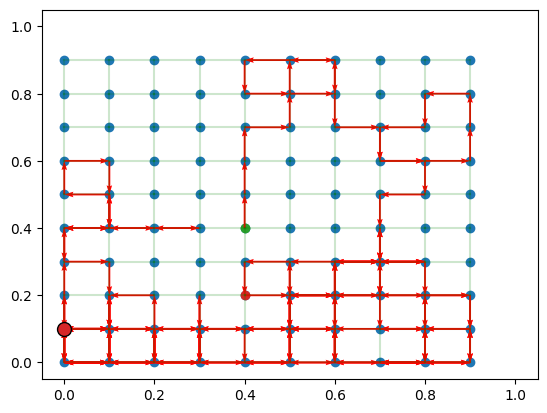

In [6]:
from typing import Optional
import torch
import torch.nn as nn

from tensordict.tensordict import TensorDict
from torchrl.data import (
    BoundedTensorSpec,
    CompositeSpec,
    UnboundedContinuousTensorSpec,
    UnboundedDiscreteTensorSpec,
)

from rl4co.envs.common.base import RL4COEnvBase
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy
from rl4co.utils.ops import gather_by_index, get_tour_length
from rl4co.utils.trainer import RL4COTrainer
from rl4co.utils.pylogger import get_pylogger
log = get_pylogger(__name__)

def _reset(self, td: Optional[TensorDict] = None, batch_size=None) -> TensorDict:
    """Reset the environment to the initial state"""
    # If no TensorDict is provided, generate a new one
    init_locs = td["locs"] if td is not None else None
    init_edges = td["edges"] if td is not None else None
    # If no batch_size is provided, use the batch_size of the initial locations
    if batch_size is None:
        batch_size = self.batch_size if init_locs is None else init_locs.shape[:-2]
    # If no device is provided, use the device of the initial locations
    device = init_locs.device if init_locs is not None else self.device 
    self.to(device)
    # If no initial locations are provided, generate new ones
    if init_locs is None:
        init_locs = self.generate_data(batch_size=batch_size).to(device)["locs"]
    if init_edges is None:
        init_edges = self.generate_data(batch_size=batch_size).to(device)["edges"]

    # If batch_size is an integer, convert it to a list
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size

    # Done mask is initialized to False
    done_mask = torch.zeros(batch_size, dtype=torch.bool, device=device)

    # Get the number of locations
    num_loc = init_locs.shape[-2]

    # Initialize a start and end node
    first_node = torch.randint(0, num_loc, (batch_size), device=device)
    # Initialize the end node to a random node until it is unequal to the start node
    while True:
        end_node = torch.randint(0, num_loc, (batch_size), device=device)
        if not torch.any(torch.eq(first_node, end_node)):
            break

    # print("end_node: ", end_node)
    # print("first_node: ", first_node)
    
    # Initialize the action mask to the manhattan distance of the nodes
    tmp = torch.zeros((*batch_size, self.num_loc, self.num_loc), dtype=torch.float32, device=device)
    for i in range(tmp.shape[0]):
        node_num = end_node[i]
        print(node_num)
        x, y = init_locs[i, node_num, 0], init_locs[i, node_num, 1]
        # print("x: ", x)
        # print("y: ", y)
        man_mat = compute_manhattan_distance(10, x*10, y*10)
        tmp[i] = torch.tensor(man_mat, dtype=torch.float32)
    
    batch_indices = torch.arange(len(first_node))
    available = init_edges[batch_indices, first_node]
    # print("available: ", available.shape)
    # print("tmp: ", tmp.shape)

    # element-wise multiplication
    # available = available * tmp[batch_indices, first_node]

    # print("available: ", available)
    # print("manhattan distances: ", tmp)

    # Initialize the index of the current node 
    i = torch.zeros((*batch_size, 1), dtype=torch.int64, device=device)

    return TensorDict(
        {
            "locs": init_locs,
            "edges": init_edges,
            "first_node": first_node,
            "current_node": first_node,
            "end_node": end_node,
            "manhattan_distance": tmp[batch_indices, first_node],
            "i": i,
            "action_mask": available,
            "reward": torch.zeros((*batch_size, 1), dtype=torch.float32),
            "done_mask": done_mask,
        },
        batch_size=batch_size,
    )

def _step(self, td: TensorDict) -> TensorDict:
    # Only update the non-done elements
    done_mask = td["done_mask"]
    #td_masked = td.masked_select(~done_mask)
    #print("td_masked action: ", td_masked["action"])
    #print("td current node: ", td["current_node"])
    current_node = torch.where(~done_mask, td["action"], td["current_node"])
    # print("current_node: ", current_node)
    # current_node = td["action"]


    # output visiting node
    # first_node = current_node if td["i"].all() == 0 else td["first_node"]

    # Mark the current node as visited
    available = get_action_mask(self, td)

    # Mask the current node to prevent revisiting
    available = available & ~td["current_node"].unsqueeze(-1).eq(torch.arange(available.shape[-1], device=available.device))

    # Create a tensor of batch indices
    # batch_indices = torch.arange(len(current_node))

    # Use advanced indexing to get the neighbors for each batch
    # neighbors = td["edges"][batch_indices, current_node]

    # Update the action_mask to only include the current node's neighbors
    # available = available & neighbors
 
    done = current_node == td["end_node"]
    # done = torch.sum(td["action_mask"], dim=-1) == 0
    done_mask |= done
    # The reward is calculated outside via get_reward for efficiency, so we set it to 0 here
    reward = torch.zeros_like(done)

    td.update(
        {
            # "first_node": first_node,
            "current_node": current_node,
            "i": td["i"] + 1,
            "action_mask": available,
            "reward": reward,
            "done": done,
            "done_mask": done_mask,
        },
    )
    return td

def get_action_mask(self, td: TensorDict) -> TensorDict:
    # Get the current node
    current_node = td["action"]

    # Create a tensor of batch indices
    batch_indices = torch.arange(len(current_node))

    # Use advanced indexing to get the neighbors for each batch
    neighbors = td["edges"][batch_indices, current_node]

    # Element-wise multiplication with the manhattan distance
    # available = neighbors * td["manhattan_distance"][batch_indices, current_node]
    available = neighbors

    # print("available: ", available)

    # Apply the heuristic to the neighbors to get the action mask
    # get the locations of the neighbors
    # locs = td["locs"]
    # locs_ordered = gather_by_index(locs, neighbors)
    return available

def get_reward(self, td, actions) -> TensorDict:
    # cumulative manhattan distance of the tour
    locs_ordered = gather_by_index(td["locs"], actions)
    diff = torch.abs(locs_ordered[:, :, 1] - locs_ordered[:, :, 0])
    distance = torch.sum(diff, dim=-1)
    
    # print("reward: ", reward)
    return -distance

def _make_spec(self, td_params):
    """Make the observation and action specs from the parameters"""
    self.observation_spec = CompositeSpec(
        locs=BoundedTensorSpec(
            low=self.min_loc,
            high=self.max_loc,
            shape=(self.num_loc, 2),
            dtype=torch.float32,
        ),
        start_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        end_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        current_node=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        i=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.int64,
        ),
        action_mask=UnboundedDiscreteTensorSpec(
            shape=(self.num_loc),
            dtype=torch.bool,
        ),
        done_mask=UnboundedDiscreteTensorSpec(
            shape=(1),
            dtype=torch.bool,
        ),
        manhattan_distance=UnboundedContinuousTensorSpec(
            shape=(self.num_loc),
            dtype=torch.float32,
        ),
        shape=(),
    )
    self.action_spec = BoundedTensorSpec(
        shape=(1,),
        dtype=torch.int64,
        low=0,
        high=self.num_loc,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(1,))
    self.done_spec = UnboundedDiscreteTensorSpec(shape=(1,), dtype=torch.bool)

def generate_data(self, batch_size) -> TensorDict:
    batch_size = [batch_size] if isinstance(batch_size, int) else batch_size
    # Generate random locations for the nodes
    locs = {}
    grid_size = 10
    for i in range(grid_size):
        for j in range(grid_size):
            x = i / grid_size
            y = j / grid_size
            locs[(i, j)] = (x, y)
    locs = torch.tensor(list(locs.values()), dtype=torch.float32)
    locs = locs.unsqueeze(0).expand(batch_size + [-1, -1])
    # Generate a random adjaceny matrix for the edges
    edges = torch.zeros((*batch_size, self.num_loc, self.num_loc), dtype=torch.bool)
    for i in range(edges.shape[0]):
        matrix = generate_adjacency_matrix(grid_size)
        edges[i] = torch.tensor(matrix, dtype=torch.bool)
    return TensorDict({"locs": locs, "edges": edges}, batch_size=batch_size)

def render(self, td, actions=None, ax=None):
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        # Create a plot of the nodes
        _, ax = plt.subplots()

    td = td.detach().cpu()

    if actions is None:
        actions = td.get("action", None)
    # if batch_size greater than 0 , we need to select the first batch element
    if td.batch_size != torch.Size([]):
        td = td[0]
        actions = actions[0]
        
    locs = td["locs"]

    # gather locs in order of action if available
    if actions is None:
        print("No action in TensorDict, rendering unsorted locs")
    else:
        actions = actions.detach().cpu()
        a_locs = gather_by_index(locs, actions, dim=0)

    # Cat the first node to the end to complete the tour
    # locs = torch.cat((locs, locs[0:1]))
    x, y = a_locs[:, 0], a_locs[:, 1]

    # Plot the visited nodes
    ax.scatter(locs[:, 0], locs[:, 1], color="tab:blue")
    
    end_node = td["end_node"]
    x_end,  y_end= locs[end_node, 0], locs[end_node, 1]
    print("end node: ", end_node)
    # Highlight the start node in green
    ax.scatter(x[0], y[0], color="tab:green")

    # Highlight the end node in red
    ax.scatter(x_end, y_end, color="tab:red")

    # Plot the edges
    edges = td["edges"]
    x_i, y_i = locs[:, 0], locs[:, 1]
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i, j]:
                ax.plot([x_i[i], x_i[j]], [y_i[i], y_i[j]], color='g', alpha=0.1)

    # Add arrows between visited nodes as a quiver plot
    dx, dy = np.diff(x), np.diff(y)
    ax.quiver(
        x[:-1], y[:-1], dx, dy, scale_units="xy", angles="xy", scale=1, color="r", alpha=1.0
    )

    # Highlight the last action
    ax.scatter(x[-1], y[-1], color="tab:red", s=100, edgecolors="black", zorder=10)

    # Setup limits and show
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)

class SPPEnv(RL4COEnvBase):
    """Traveling Salesman Problem (TSP) environment"""

    name = "tsp"

    def __init__(
        self,
        num_loc: int = 20,
        min_loc: float = 0,
        max_loc: float = 1,
        td_params: TensorDict = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.num_loc = num_loc
        self.min_loc = min_loc
        self.max_loc = max_loc
        self._make_spec(td_params)

    _reset = _reset
    _step = _step
    get_reward = get_reward
    # check_solution_validity = check_solution_validity
    get_action_mask = get_action_mask
    _make_spec = _make_spec
    generate_data = generate_data
    render = render

def random_policy(td):
    """Helper function to select a random action from available actions"""
    print("action mask: ", td["action_mask"])
    #print("greedy action: ", torch.argmax(td["action_mask"], 1))
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    print("random action: ", action)
    td.set("action", action)
    return td

def greedy(td):
    """Select the action with the highest probability."""
    print("action mask: ", td["action_mask"])
    print("end node: ", td["end_node"])
    action = torch.argmax(td["action_mask"], 1)
    print("greedy action: ", action)
    td.set("action", action)
    return td

def rollout(env, td, policy, max_steps: int = None):
    """Helper function to rollout a policy. Currently, TorchRL does not allow to step
    over envs when done with `env.rollout()`. We need this because for environments that complete at different steps.
    """

    max_steps = float("inf") if max_steps is None else max_steps
    actions = []
    steps = 0
    done_mask = torch.zeros(td.batch_size, dtype=torch.bool, device=td.device)

    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]

        # # Select non-done actions
        # td_masked = td.masked_select(~done_mask)

        # # Apply the policy to the non-done actions
        # td_masked = policy(td_masked)

        # # Update the action tensor
        # action = torch.where(~done_mask, td_masked["action"], td["current_node"])

        # # Update td with actions
        # td.set("action", action)
        # actions.append(td["action"])
        
        # print("action: ", action)
        # print("done: ", td["done"])

        # # Perform the next step
        # td = env.step(td)["next"]
        
        # # Update the done mask
        # done_mask |= td["done"]

        steps += 1
        if steps > max_steps:
            log.info("Max steps reached")
            break
    return (
        env.get_reward(td, torch.stack(actions, dim=1)),
        td,
        torch.stack(actions, dim=1),
    )

# from rl4co.utils.decoding import rollout, random_policy

batch_size = 3

env = SPPEnv(num_loc=100)
reward, td, actions = rollout(env, env.reset(batch_size=batch_size), random_policy)
print(reward)
env.render(td, actions)

In [7]:

class SPPInitEmbedding(nn.Module):
    """Initial embedding for the Shortest Path Problem (SPP) environment.
    Embed the following node features to the embedding space:
        - locs: x, y coordinates of the nodes
        - target: x, y coordinates of the target node
    """

    def __init__(self, embedding_dim, linear_bias=True):
        super(SPPInitEmbedding, self).__init__()
        node_dim = 1 # distance_to_target
        self.init_embed = nn.Linear(node_dim, embedding_dim, linear_bias)

    def forward(self, td):
        locs = td["locs"]
        print("locs: ", locs.shape)
        target = td["end_node"]
        print("target: ", target.shape)

        batch_indices = torch.arange(len(target))
        target = locs[batch_indices, target].unsqueeze(1)

        print("target: ", target.shape)
        print(target)

        # Compute the distance to the target
        distance_to_target = torch.norm(locs - target, dim=-1, keepdim=True)
        print("distance_to_target: ", distance_to_target.shape)
        print(distance_to_target)
        
        edges = td["edges"]

        print("edges: ", edges.shape)

        # concat the edges to every node
        # edges = edges.unsqueeze(1).expand(-1, locs.shape[1], -1, -1)
        # print("edges: ", edges.shape)
        
        locs_and_edges = torch.cat([locs, edges], dim=2)
        print("locs_and_edges: ", locs_and_edges.shape)

        locs_and_distance = torch.cat([locs, distance_to_target], dim=2)

        # Get neighbor indices
        # neighbor_indices = edges.nonzero(as_tuple=True)[1].reshape(locs.shape[1], -1)

        # # Get neighbor embeddings
        # neighbor_embeddings = self.init_embed(locs[:, neighbor_indices])

        # # Aggregate neighbor embeddings
        # aggregated_neighbor_embeddings = neighbor_embeddings.sum(dim=2)

        # # Get node embeddings
        # node_embeddings = self.init_embed(locs)

        # # Concatenate node embeddings and aggregated neighbor embeddings
        # out = torch.cat([node_embeddings, aggregated_neighbor_embeddings], dim=2)
        # print("out: ", out)
        # Concatenate the locs and target to form the input tensor
        #node_and_target = torch.cat([locs, target], dim=2)
        out = self.init_embed(distance_to_target)
        return out

In [33]:
class SPPContext(nn.Module):
    """Context embedding for the Shortest Path Problem (SPP).
    Project the following to the embedding space:
        - first node embedding
        - current node embedding
        - target node embedding
    """

    def __init__(self, embedding_dim,  linear_bias=True):
        super(SPPContext, self).__init__()
        self.W_placeholder = nn.Parameter(
            torch.Tensor(2 * embedding_dim).uniform_(-1, 1)
        )
        self.project_context = nn.Linear(
            embedding_dim*2, embedding_dim, bias=linear_bias
        )

    def forward(self, embeddings, td):
        batch_size = embeddings.size(0)
        # By default, node_dim = -1 (we only have one node embedding per node)
        node_dim = (
            (-1,) if td["first_node"].dim() == 1 else (td["first_node"].size(-1), -1)
        )
        if td["i"][(0,) * td["i"].dim()].item() < 1:  # get first item fast
            context_embedding = self.W_placeholder[None, :].expand(
                batch_size, self.W_placeholder.size(-1)
            )
        else:
            context_embedding = gather_by_index(
                embeddings,
                torch.stack([td["first_node"], td["current_node"]], -1).view(
                    batch_size, -1
                ),
            ).view(batch_size, *node_dim)
        return self.project_context(context_embedding)

In [10]:
class StaticEmbedding(nn.Module):
    def __init__(self, *args, **kwargs):
        super(StaticEmbedding, self).__init__()

    def forward(self, td):
        return 0, 0, 0

In [39]:
env = SPPEnv(num_loc=100)

# policy = AttentionModelPolicy(env.name, 
#                               embedding_dim=128, 
#                               num_encoder_layers=3,
#                               num_heads=8,)

# policy = AutoregressivePolicy(
#     env=env,
#     model=policy,
#     max_steps=100,
#     rollout_fn=rollout,
#     rollout_kwargs={"policy": greedy},
# )

# Instantiate policy with the embeddings we created above
emb_dim = 128
policy = AutoregressivePolicy(env,
                              embedding_dim=emb_dim,
                              init_embedding=SPPInitEmbedding(emb_dim),
                              context_embedding=SPPContext(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)

# model = AttentionModel(env, baseline="rollout",
#                        policy=policy,
#                        train_data_size=100_000,
#                        val_data_size=100_00,
#                        optimizer_kwargs= {"lr": 1e-4},)

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       policy=policy,
                       batch_size=2,
                       baseline='rollout',
                       train_data_size=10,
                       val_data_size=10,)

/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


tensor(85)
tensor(73)
tensor(31)
locs:  torch.Size([3, 100, 2])
target:  torch.Size([3])
target:  torch.Size([3, 1, 2])
tensor([[[0.8000, 0.5000]],

        [[0.7000, 0.3000]],

        [[0.3000, 0.1000]]], device='cuda:0')
distance_to_target:  torch.Size([3, 100, 1])
tensor([[[0.9434],
         [0.8944],
         [0.8544],
         [0.8246],
         [0.8062],
         [0.8000],
         [0.8062],
         [0.8246],
         [0.8544],
         [0.8944],
         [0.8602],
         [0.8062],
         [0.7616],
         [0.7280],
         [0.7071],
         [0.7000],
         [0.7071],
         [0.7280],
         [0.7616],
         [0.8062],
         [0.7810],
         [0.7211],
         [0.6708],
         [0.6325],
         [0.6083],
         [0.6000],
         [0.6083],
         [0.6325],
         [0.6708],
         [0.7211],
         [0.7071],
         [0.6403],
         [0.5831],
         [0.5385],
         [0.5099],
         [0.5000],
         [0.5099],
         [0.5385],
         

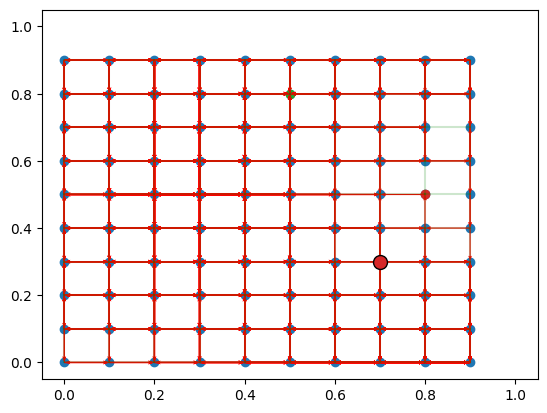

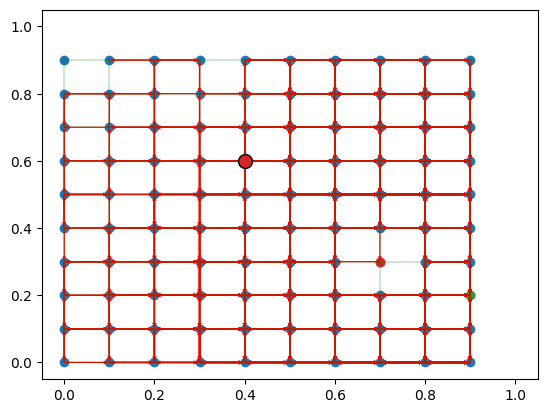

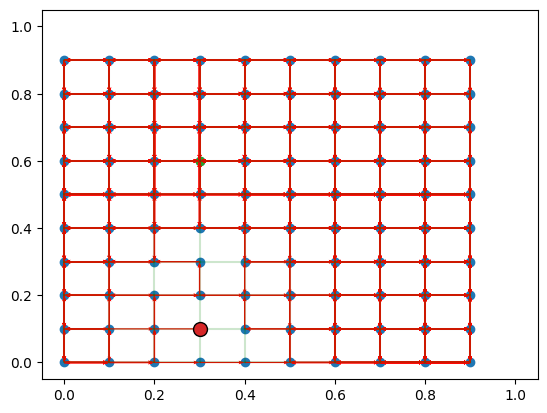

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="sampling", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [43]:
model.policy.train_decode_type = "sampling"
trainer = RL4COTrainer(
    max_epochs=1,
    accelerator="gpu",
    devices=1,
    logger=None
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | SPPEnv               | 0     
1 | policy   | AutoregressivePolicy | 710 K 
2 | baseline | WarmupBaseline       | 710 K 
--------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)


tensor(84, device='cuda:0')
tensor(49, device='cuda:0')
locs:  torch.Size([2, 100, 2])
target:  torch.Size([2])
target:  torch.Size([2, 1, 2])
tensor([[[0.8000, 0.4000]],

        [[0.4000, 0.9000]]], device='cuda:0')
distance_to_target:  torch.Size([2, 100, 1])
tensor([[[0.8944],
         [0.8544],
         [0.8246],
         [0.8062],
         [0.8000],
         [0.8062],
         [0.8246],
         [0.8544],
         [0.8944],
         [0.9434],
         [0.8062],
         [0.7616],
         [0.7280],
         [0.7071],
         [0.7000],
         [0.7071],
         [0.7280],
         [0.7616],
         [0.8062],
         [0.8602],
         [0.7211],
         [0.6708],
         [0.6325],
         [0.6083],
         [0.6000],
         [0.6083],
         [0.6325],
         [0.6708],
         [0.7211],
         [0.7810],
         [0.6403],
         [0.5831],
         [0.5385],
         [0.5099],
         [0.5000],
         [0.5099],
         [0.5385],
         [0.5831],
         [0.640

`Trainer.fit` stopped: `max_epochs=1` reached.


tensor(22, device='cuda:0')
tensor(77, device='cuda:0')
locs:  torch.Size([2, 100, 2])
target:  torch.Size([2])
target:  torch.Size([2, 1, 2])
tensor([[[0.2000, 0.2000]],

        [[0.7000, 0.7000]]], device='cuda:0')
distance_to_target:  torch.Size([2, 100, 1])
tensor([[[0.2828],
         [0.2236],
         [0.2000],
         [0.2236],
         [0.2828],
         [0.3606],
         [0.4472],
         [0.5385],
         [0.6325],
         [0.7280],
         [0.2236],
         [0.1414],
         [0.1000],
         [0.1414],
         [0.2236],
         [0.3162],
         [0.4123],
         [0.5099],
         [0.6083],
         [0.7071],
         [0.2000],
         [0.1000],
         [0.0000],
         [0.1000],
         [0.2000],
         [0.3000],
         [0.4000],
         [0.5000],
         [0.6000],
         [0.7000],
         [0.2236],
         [0.1414],
         [0.1000],
         [0.1414],
         [0.2236],
         [0.3162],
         [0.4123],
         [0.5099],
         [0.608

locs:  torch.Size([3, 100, 2])
target:  torch.Size([3])
target:  torch.Size([3, 1, 2])
tensor([[[0.8000, 0.5000]],

        [[0.7000, 0.3000]],

        [[0.3000, 0.1000]]], device='cuda:0')
distance_to_target:  torch.Size([3, 100, 1])
tensor([[[0.9434],
         [0.8944],
         [0.8544],
         [0.8246],
         [0.8062],
         [0.8000],
         [0.8062],
         [0.8246],
         [0.8544],
         [0.8944],
         [0.8602],
         [0.8062],
         [0.7616],
         [0.7280],
         [0.7071],
         [0.7000],
         [0.7071],
         [0.7280],
         [0.7616],
         [0.8062],
         [0.7810],
         [0.7211],
         [0.6708],
         [0.6325],
         [0.6083],
         [0.6000],
         [0.6083],
         [0.6325],
         [0.6708],
         [0.7211],
         [0.7071],
         [0.6403],
         [0.5831],
         [0.5385],
         [0.5099],
         [0.5000],
         [0.5099],
         [0.5385],
         [0.5831],
         [0.6403],
    

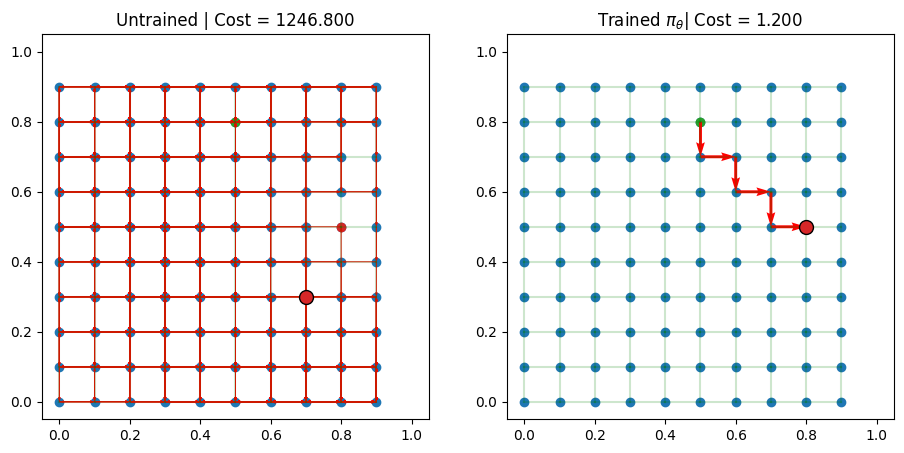

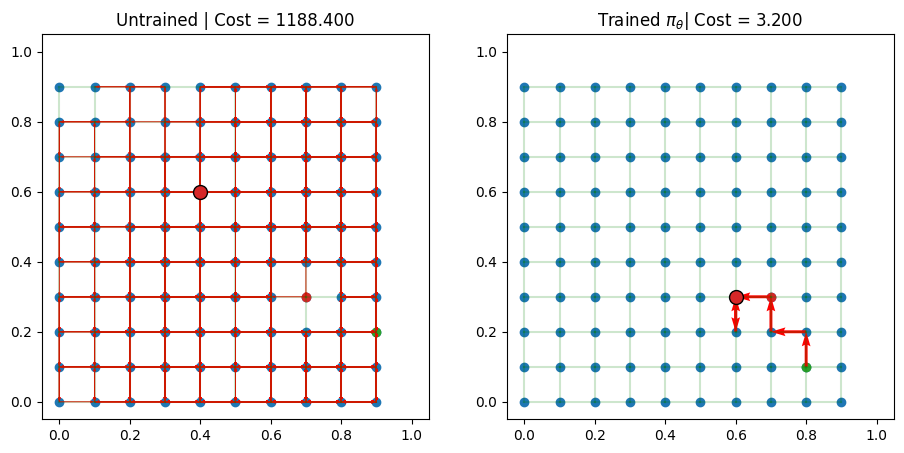

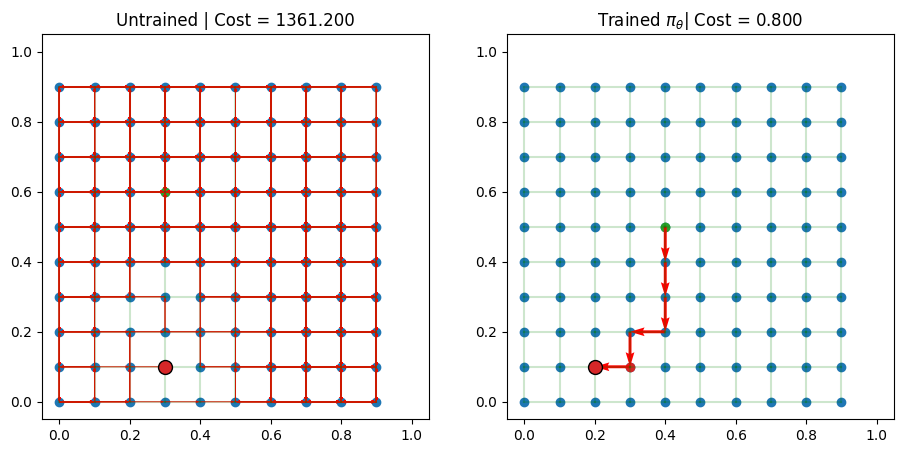

In [47]:
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")